# Stacked GRU for time series prediction

In this tutorial, we show how to quickly set up and train an RNN regression model with the deep4cast package. The goal is to show you how to handle the package interface and inspect the model object after training. The example data constitutes of a monthly 26-dimensional multivariate time series.

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_table

from deep4cast.forecasters import Forecaster
import deep4cast.topologies as topologies
import deep4cast.custom_metrics as metrics

%matplotlib inline

# Fix random number seed for reproducibility
np.random.seed(3) 

## Data preparation

Text(0,0.5,'Quantity')

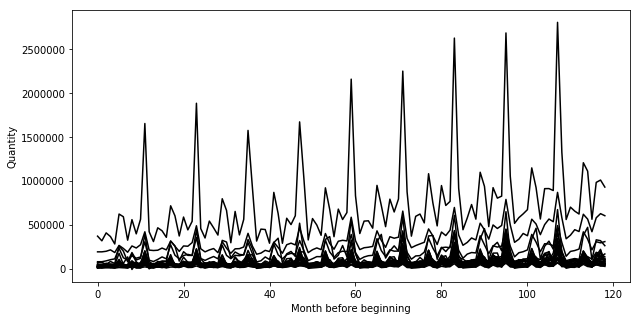

In [55]:
# Load the data from file
filename = 'timeseries_data.csv'
df = read_table(filename, sep=',')

# Prepare the data set
data = df.values
data = np.expand_dims(data, 0)

# We just need a small holdout dataset for evaluation purposes
holdout = 9
train_data = data[:,:-9,:]
test_data = data[:,-9:,:]

# Plot the dataset
plt.figure(figsize=(10,5))
plt.plot(data[0,:,:], 'k')
plt.xlabel('Month before beginning')
plt.ylabel('Quantity')

## Recurrent Neural Network Forecaster using GRU cells

In [213]:
topology = topologies.StackedGRU(units=128, num_layers=4)

In [214]:
forecaster = Forecaster(
    topology,
    lag=60,  # This is the number of time steps used to predict the future for each data point
    horizon=9,  # This is how many time steps into the future we want to produce
    lr=0.001,  # This is the learning rate for the optimizer
    epochs=500  # Maximum number of epochs that the optimizer will perform
)

In [215]:
forecaster.fit(train_data, verbose=0)

Text(0,0.5,'Loss')

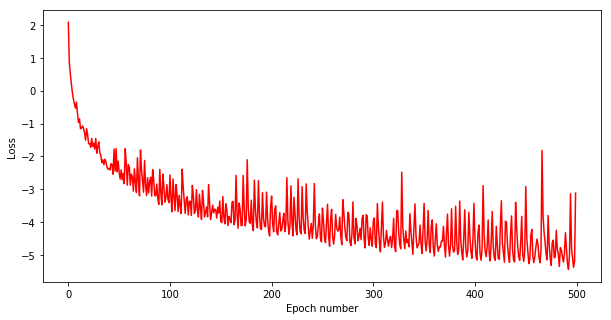

In [216]:
plt.figure(figsize=(10,5))
plt.plot(forecaster.history.epoch, forecaster.history.history['loss'], 'r')
plt.xlabel('Epoch number')
plt.ylabel('Loss')

In [217]:
predictions = forecaster.predict(data=train_data, n_samples=1000)  # Draw 100 samples for predictions

In [218]:
print('MSE: {}'.format(round(metrics.mse(predictions['mean'], test_data), 2)))
print('MAPE: {}%'.format(round(metrics.mape(predictions['mean'], test_data), 2)))
print('SMAPE: {}%'.format(round(metrics.smape(predictions['mean'], test_data), 2)))

MSE: 939878533.8
MAPE: 14.3%
SMAPE: 15.49%


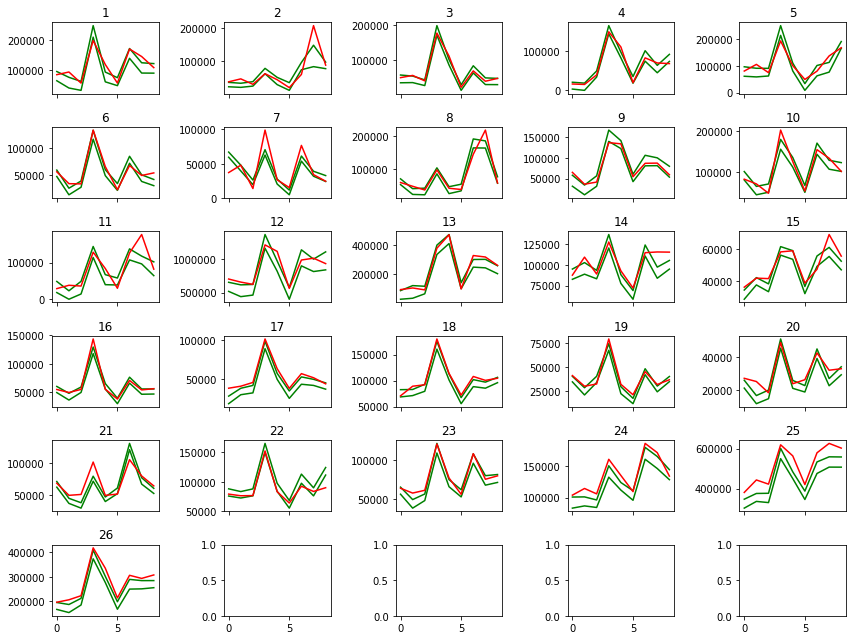

In [219]:
ncols = 5
fig, axes = plt.subplots(nrows=26//ncols+1, ncols=ncols, sharex=True, figsize=(12, 9))
for ax, ya, yl, yu, title in zip(axes.flat, 
                             test_data[0,:,:].T,
                             predictions['lower_quantile'][0,:,:].T,
                             predictions['upper_quantile'][0,:,:].T,
                             range(1,26+1)):
    ax.plot(yl, 'g-')
    ax.plot(yu, 'g-')
    ax.plot(ya, 'r-')
    ax.set_title(title)

plt.tight_layout()